In [19]:
!pip install umap-learn


Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_896383/2362296952.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)
100%

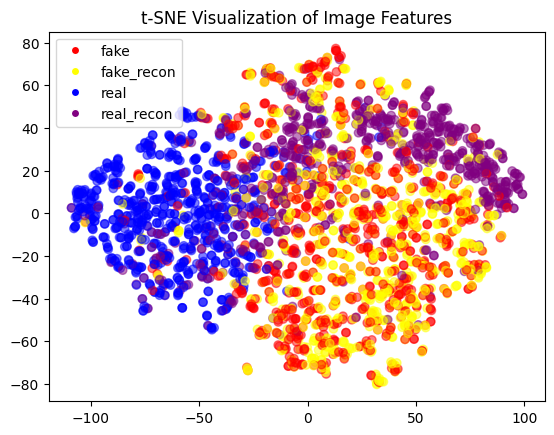

In [20]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Model import
from network.models import get_models # Replace with actual model import
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class label mapping
CLASS_LABEL = {
    'ai_crop': 'fake',
    'ai_inpainting': 'fake_recon',
    'nature_crop': 'real',
    'nature_inpainting': 'real_recon'
}

def get_image_files_with_labels(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    labels = []

    for category in os.listdir(folder_path):  
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for sub_category in os.listdir(category_path):  
                sub_category_path = os.path.join(category_path, sub_category)
                if os.path.isdir(sub_category_path):
                    key = f"{category}_{sub_category}"
                    if key in CLASS_LABEL:
                        class_label = CLASS_LABEL[key]
                        for file in os.listdir(sub_category_path):
                            if any(file.lower().endswith(ext) for ext in extensions):
                                image_paths.append(os.path.join(sub_category_path, file))
                                labels.append(class_label)
                    else:
                        print(f"Warning: '{key}' not found in CLASS_LABEL")

    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined[:3000])

    return list(image_paths), list(labels)

# Load model
model_path = '/mnt/work/deepfake_detector/output/GenImage/2/convnext_base_in22k_224ext_0203_4/weights/last_acc0.9994.pth'
model = get_models(model_name="convnext_base_in22k", num_classes=2, embedding_size=1024, freeze_extractor=True).to(device)
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get image files and labels
folder_path = folder_path = '/mnt/work/deepfake_detector/DR/GenImage/stable_diffusion_v_1_4/imagenet_ai_0419_sdv4/train'
image_paths, labels = get_image_files_with_labels(folder_path)

# Extract features
tu_features = []
for image_path in tqdm(image_paths):
    img = Image.open(image_path).convert('RGB')
    t_img = Variable(transform(img).unsqueeze(0))
    t_img = t_img.to(device)
    with torch.no_grad():
        features = model(t_img, return_feature=True)[1].squeeze()
    tu_features.append(features)

# Convert to numpy array
tu_features_np = [feature.detach().cpu().numpy() for feature in tu_features]
features = np.array(tu_features_np)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=5).fit_transform(features)


tx = tsne[:, 0]
ty = tsne[:, 1]

# Define color mapping for 4 classes
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels]

# Visualization
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in color_map.items()])
plt.title("t-SNE Visualization of Image Features")
plt.show()

features1 = features
labels1 = labels    

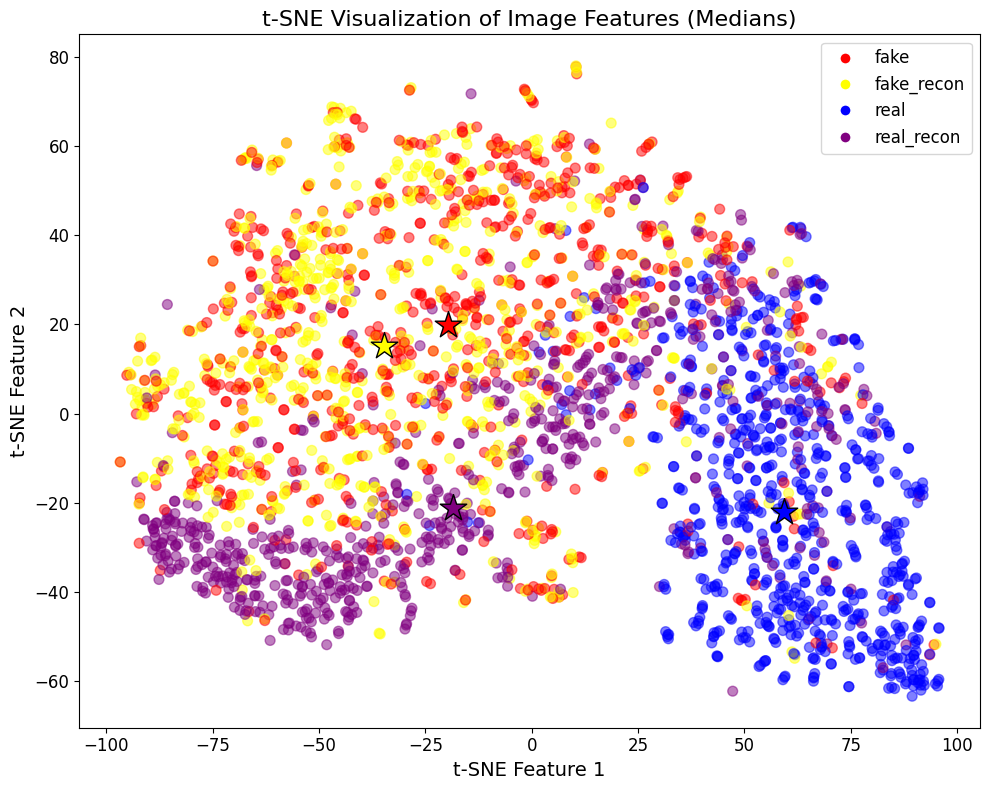

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# t-SNE 계산 (기존 코드와 동일)
tsne = TSNE(n_components=2, perplexity=10, learning_rate=1000).fit_transform(features1)

tx = tsne[:, 0]
ty = tsne[:, 1]

# 색상 매핑 (기존 코드와 동일)
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels1]

# 중앙값 계산 (기존 코드와 동일)
cluster_medians = {}
for label in color_map:
    indices = [i for i, l in enumerate(labels1) if l == label]
    if indices:
        cluster_tx = np.median(tx[indices])
        cluster_ty = np.median(ty[indices])
        cluster_medians[label] = (cluster_tx, cluster_ty)

# 시각화 (개선된 부분)
plt.figure(figsize=(10, 8))  # Figure 크기 확대
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5, s=50)  # 점 크기 확대

# 중앙값 강조 표시
for label, (center_tx, center_ty) in cluster_medians.items():
    plt.scatter(center_tx, center_ty, marker='*', s=400,  # 마커 크기 확대
                color=color_map[label], label=f'{label} Median',  # 레이블에 Median 명시
                edgecolors='black', linewidths=1)  # 마커 테두리 추가

# 범례 (개선된 부분)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=8) for label, color in color_map.items()]  # 범례 마커 크기 확대
# handles.extend([plt.Line2D([0], [0], marker='*', markersize=15,  # 범례 중앙값 마커 크기 확대
#                             color=color_map[label], label=f'{label} Median',
#                             markeredgecolor='black') for label in color_map])  # 범례 마커 테두리 추가
plt.legend(handles=handles, fontsize=12)  # 범례 글자 크기 확대

plt.title("t-SNE Visualization of Image Features (Medians)", fontsize=16)  # 제목 글자 크기 확대
plt.xlabel("t-SNE Feature 1", fontsize=14)  # 축 레이블 글자 크기 확대
plt.ylabel("t-SNE Feature 2", fontsize=14)
plt.xticks(fontsize=12)  # 축 눈금 글자 크기 확대
plt.yticks(fontsize=12)

plt.tight_layout()  # 여백 조정
plt.show()

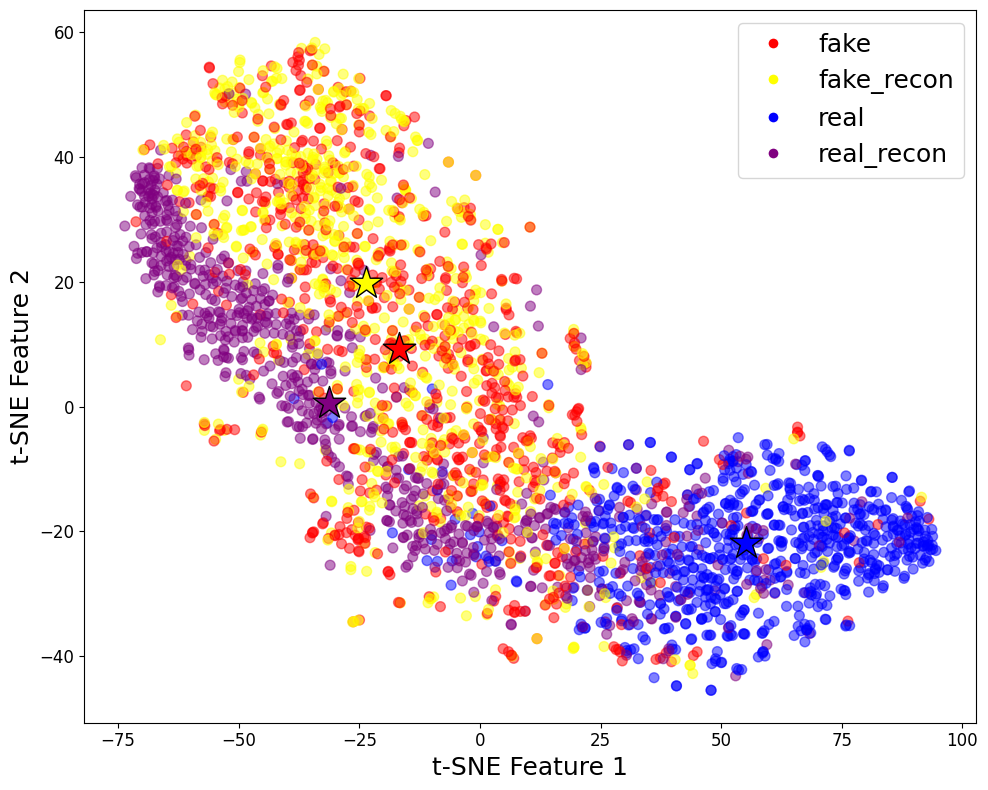

<Figure size 640x480 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# t-SNE 계산 (기존 코드와 동일)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=1000).fit_transform(features1)

tx = tsne[:, 0]
ty = tsne[:, 1]

# 색상 매핑 (기존 코드와 동일)
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels1]

# 중앙값 계산 (기존 코드와 동일)
cluster_medians = {}
for label in color_map:
    indices = [i for i, l in enumerate(labels1) if l == label]
    if indices:
        cluster_tx = np.median(tx[indices])
        cluster_ty = np.median(ty[indices])
        cluster_medians[label] = (cluster_tx, cluster_ty)

# 시각화 (개선된 부분)
plt.figure(figsize=(10, 8))  # Figure 크기 확대
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5, s=50)  # 점 크기 확대

# 중앙값 강조 표시
for label, (center_tx, center_ty) in cluster_medians.items():
    plt.scatter(center_tx, center_ty, marker='*', s=600,  # 마커 크기 확대
                color=color_map[label], label=f'{label} Median',  # 레이블에 Median 명시
                edgecolors='black', linewidths=1)  # 마커 테두리 추가

# 범례 (개선된 부분)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=8) for label, color in color_map.items()]  # 범례 마커 크기 확대
# handles.extend([plt.Line2D([0], [0], marker='*', markersize=15,  # 범례 중앙값 마커 크기 확대
#                             color=color_map[label], label=f'{label} Median',
#                             markeredgecolor='black') for label in color_map])  # 범례 마커 테두리 추가
plt.legend(handles=handles, fontsize=18)  # 범례 글자 크기 확대

plt.xlabel("t-SNE Feature 1", fontsize=18)  # 축 레이블 글자 크기 확대
plt.ylabel("t-SNE Feature 2", fontsize=18)
plt.xticks(fontsize=12)  # 축 눈금 글자 크기 확대
plt.yticks(fontsize=12)

plt.tight_layout()  # 여백 조정
plt.show()
plt.savefig("manhattan.png")

/tmp/ipykernel_896383/4006816704.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)
100%

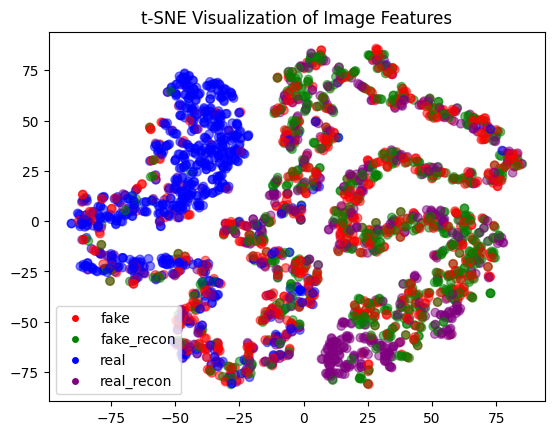

In [22]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Model import
from network.models import get_models # Replace with actual model import
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class label mapping
CLASS_LABEL = {
    'ai_crop': 'fake',
    'ai_inpainting': 'fake_recon',
    'nature_crop': 'real',
    'nature_inpainting': 'real_recon'
}

def get_image_files_with_labels(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    labels = []

    for category in os.listdir(folder_path):  
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for sub_category in os.listdir(category_path):  
                sub_category_path = os.path.join(category_path, sub_category)
                if os.path.isdir(sub_category_path):
                    key = f"{category}_{sub_category}"
                    if key in CLASS_LABEL:
                        class_label = CLASS_LABEL[key]
                        for file in os.listdir(sub_category_path):
                            if any(file.lower().endswith(ext) for ext in extensions):
                                image_paths.append(os.path.join(sub_category_path, file))
                                labels.append(class_label)
                    else:
                        print(f"Warning: '{key}' not found in CLASS_LABEL")

    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined[:3000])

    return list(image_paths), list(labels)

# Load model
model_path = '/mnt/work/deepfake_detector/output/GenImage/2/convnext_base_in22k_224ext_full_drct_17epoch_64/weights/last_acc0.9996.pth'
model = get_models(model_name="convnext_base_in22k", num_classes=2, embedding_size=1024, freeze_extractor=True).to(device)
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get image files and labels
folder_path = folder_path = '/mnt/work/deepfake_detector/DR/GenImage/stable_diffusion_v_1_4/imagenet_ai_0419_sdv4/train'
image_paths, labels = get_image_files_with_labels(folder_path)

# Extract features
tu_features = []
for image_path in tqdm(image_paths):
    img = Image.open(image_path).convert('RGB')
    t_img = Variable(transform(img).unsqueeze(0))
    t_img = t_img.to(device)
    with torch.no_grad():
        features = model(t_img, return_feature=True)[1].squeeze()
    tu_features.append(features)

# Convert to numpy array
tu_features_np = [feature.detach().cpu().numpy() for feature in tu_features]
features = np.array(tu_features_np)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=5).fit_transform(features)


tx = tsne[:, 0]
ty = tsne[:, 1]

# Define color mapping for 4 classes
color_map = {
    'fake': 'red',
    'fake_recon': 'green',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels]

# Visualization
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in color_map.items()])
plt.title("t-SNE Visualization of Image Features")
plt.show()

features2 = features
labels2 = labels


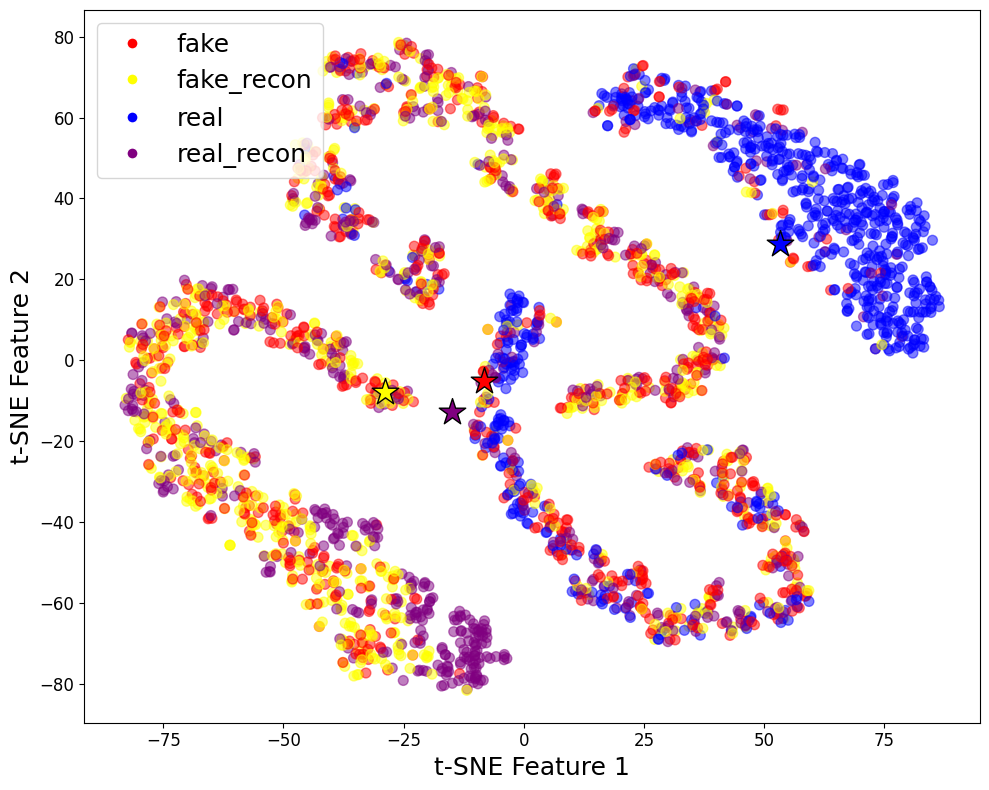

<Figure size 640x480 with 0 Axes>

In [56]:

tsne = TSNE(n_components=2, perplexity=10, learning_rate=1000).fit_transform(features2)

tx = tsne[:, 0]
ty = tsne[:, 1]

# 색상 매핑 (기존 코드와 동일)
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels2]

# 중앙값 계산 (기존 코드와 동일)
cluster_medians = {}
for label in color_map:
    indices = [i for i, l in enumerate(labels2) if l == label]
    if indices:
        cluster_tx = np.median(tx[indices])
        cluster_ty = np.median(ty[indices])
        cluster_medians[label] = (cluster_tx, cluster_ty)

# 시각화 (개선된 부분)
plt.figure(figsize=(10, 8))  # Figure 크기 확대
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5, s=50)  # 점 크기 확대

# 중앙값 강조 표시
for label, (center_tx, center_ty) in cluster_medians.items():
    plt.scatter(center_tx, center_ty, marker='*', s=400,  # 마커 크기 확대
                color=color_map[label], label=f'{label} Median',  # 레이블에 Median 명시
                edgecolors='black', linewidths=1)  # 마커 테두리 추가

# 범례 (개선된 부분)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=8) for label, color in color_map.items()]  # 범례 마커 크기 확대
# handles.extend([plt.Line2D([0], [0], marker='*', markersize=15,  # 범례 중앙값 마커 크기 확대
#                             color=color_map[label], label=f'{label} Median',
#                             markeredgecolor='black') for label in color_map])  # 범례 마커 테두리 추가
plt.legend(handles=handles, fontsize=18)  # 범례 글자 크기 확대


plt.xlabel("t-SNE Feature 1", fontsize=18)  # 축 레이블 글자 크기 확대
plt.ylabel("t-SNE Feature 2", fontsize=18)
plt.xticks(fontsize=12)  # 축 눈금 글자 크기 확대
plt.yticks(fontsize=12)

plt.tight_layout()  # 여백 조정
plt.show()
plt.savefig("drct.png")

/tmp/ipykernel_896383/2611158693.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)
100%

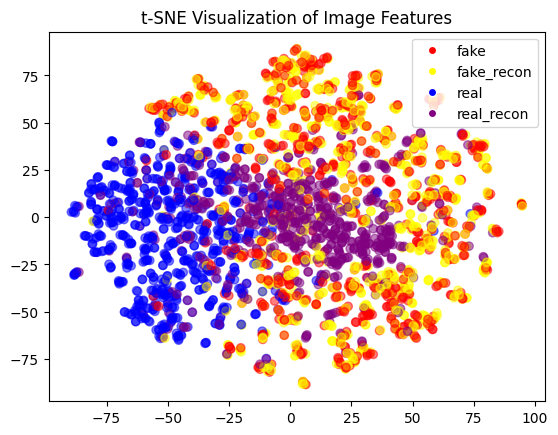

In [24]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Model import
from network.models import get_models # Replace with actual model import
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class label mapping
CLASS_LABEL = {
    'ai_crop': 'fake',
    'ai_inpainting': 'fake_recon',
    'nature_crop': 'real',
    'nature_inpainting': 'real_recon'
}

def get_image_files_with_labels(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    labels = []

    for category in os.listdir(folder_path):  
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for sub_category in os.listdir(category_path):  
                sub_category_path = os.path.join(category_path, sub_category)
                if os.path.isdir(sub_category_path):
                    key = f"{category}_{sub_category}"
                    if key in CLASS_LABEL:
                        class_label = CLASS_LABEL[key]
                        for file in os.listdir(sub_category_path):
                            if any(file.lower().endswith(ext) for ext in extensions):
                                image_paths.append(os.path.join(sub_category_path, file))
                                labels.append(class_label)
                    else:
                        print(f"Warning: '{key}' not found in CLASS_LABEL")

    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined[:3000])

    return list(image_paths), list(labels)

# Load model
model_path = '/mnt/work/deepfake_detector/output/GenImage/2/convnext_base_in22k_224ext_0131_1/weights/4_acc0.9996.pth'
model = get_models(model_name="convnext_base_in22k", num_classes=2, embedding_size=1024, freeze_extractor=True).to(device)
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get image files and labels
folder_path = folder_path = '/mnt/work/deepfake_detector/DR/GenImage/stable_diffusion_v_1_4/imagenet_ai_0419_sdv4/train'
image_paths, labels = get_image_files_with_labels(folder_path)

# Extract features
tu_features = []
for image_path in tqdm(image_paths):
    img = Image.open(image_path).convert('RGB')
    t_img = Variable(transform(img).unsqueeze(0))
    t_img = t_img.to(device)
    with torch.no_grad():
        features = model(t_img, return_feature=True)[1].squeeze()
    tu_features.append(features)

# Convert to numpy array
tu_features_np = [feature.detach().cpu().numpy() for feature in tu_features]
features = np.array(tu_features_np)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=5).fit_transform(features)


tx = tsne[:, 0]
ty = tsne[:, 1]

# Define color mapping for 4 classes
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels]

# Visualization
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in color_map.items()])
plt.title("t-SNE Visualization of Image Features")
plt.show()

features3 = features
labels3 = labels


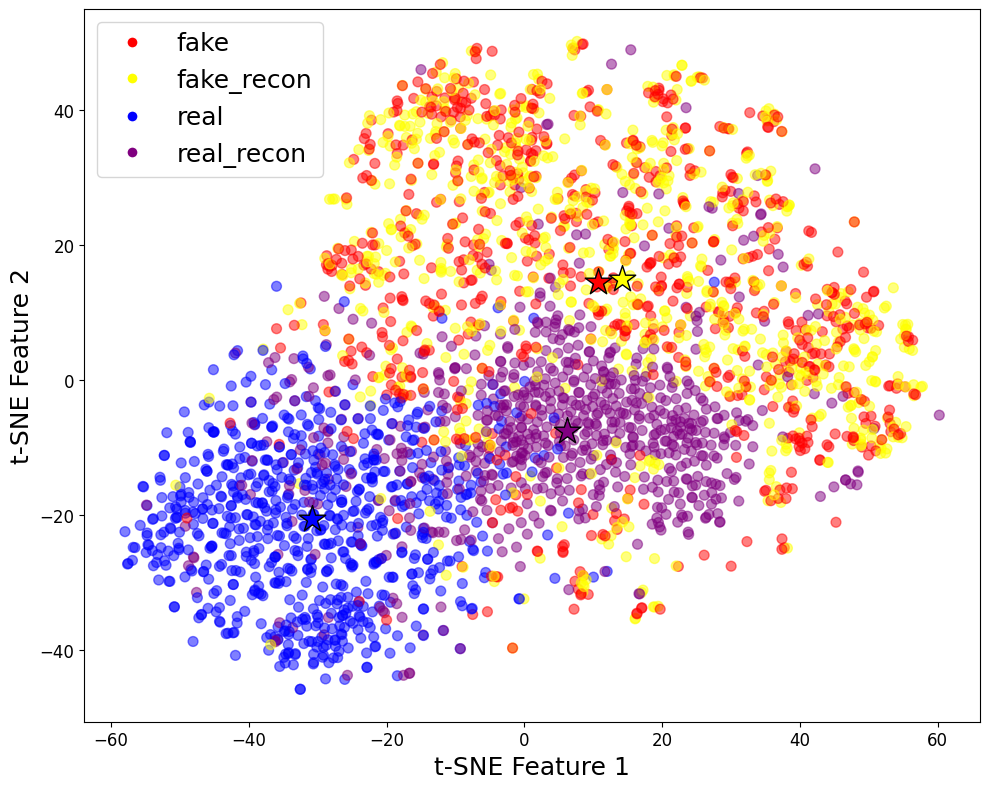

<Figure size 640x480 with 0 Axes>

In [48]:

tsne = TSNE(n_components=2, perplexity=50, learning_rate=1000).fit_transform(features3)

tx = tsne[:, 0]
ty = tsne[:, 1]

# 색상 매핑 (기존 코드와 동일)
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels3]

# 중앙값 계산 (기존 코드와 동일)
cluster_medians = {}
for label in color_map:
    indices = [i for i, l in enumerate(labels3) if l == label]
    if indices:
        cluster_tx = np.median(tx[indices])
        cluster_ty = np.median(ty[indices])
        cluster_medians[label] = (cluster_tx, cluster_ty)

# 시각화 (개선된 부분)
plt.figure(figsize=(10, 8))  # Figure 크기 확대
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5, s=50)  # 점 크기 확대

# 중앙값 강조 표시
for label, (center_tx, center_ty) in cluster_medians.items():
    plt.scatter(center_tx, center_ty, marker='*', s=400,  # 마커 크기 확대
                color=color_map[label], label=f'{label} Median',  # 레이블에 Median 명시
                edgecolors='black', linewidths=1)  # 마커 테두리 추가

# 범례 (개선된 부분)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=8) for label, color in color_map.items()]  # 범례 마커 크기 확대
# handles.extend([plt.Line2D([0], [0], marker='*', markersize=15,  # 범례 중앙값 마커 크기 확대
#                             color=color_map[label], label=f'{label} Median',
#                             markeredgecolor='black') for label in color_map])  # 범례 마커 테두리 추가
plt.legend(handles=handles, fontsize=18)  # 범례 글자 크기 확대

plt.xlabel("t-SNE Feature 1", fontsize=18)  # 축 레이블 글자 크기 확대
plt.ylabel("t-SNE Feature 2", fontsize=18)
plt.xticks(fontsize=12)  # 축 눈금 글자 크기 확대
plt.yticks(fontsize=12)

plt.tight_layout()  # 여백 조정
plt.show()
plt.savefig("cos.png")

100%|██████████| 3000/3000 [06:41<00:00,  7.47it/s]


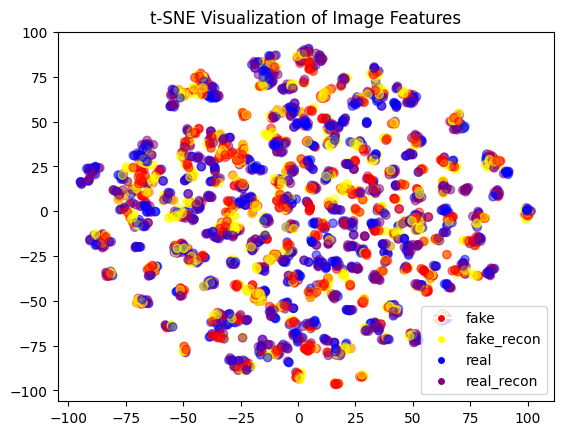

In [26]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Model import
from network.models import get_models # Replace with actual model import
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class label mapping
CLASS_LABEL = {
    'ai_crop': 'fake',
    'ai_inpainting': 'fake_recon',
    'nature_crop': 'real',
    'nature_inpainting': 'real_recon'
}

def get_image_files_with_labels(folder_path, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    labels = []

    for category in os.listdir(folder_path):  
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for sub_category in os.listdir(category_path):  
                sub_category_path = os.path.join(category_path, sub_category)
                if os.path.isdir(sub_category_path):
                    key = f"{category}_{sub_category}"
                    if key in CLASS_LABEL:
                        class_label = CLASS_LABEL[key]
                        for file in os.listdir(sub_category_path):
                            if any(file.lower().endswith(ext) for ext in extensions):
                                image_paths.append(os.path.join(sub_category_path, file))
                                labels.append(class_label)
                    else:
                        print(f"Warning: '{key}' not found in CLASS_LABEL")

    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined[:3000])

    return list(image_paths), list(labels)

# Load model
# model_path = '/mnt/work/deepfake_detector/output/GenImage/2/convnext_base_in22k_224ext_0131_1/weights/4_acc0.9996.pth'
model = get_models(model_name="convnext_base_in22k", num_classes=2, embedding_size=1024, freeze_extractor=True).to(device)
# model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=not True)

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get image files and labels
folder_path = folder_path = '/mnt/work/deepfake_detector/DR/GenImage/stable_diffusion_v_1_4/imagenet_ai_0419_sdv4/train'
image_paths, labels = get_image_files_with_labels(folder_path)

# Extract features
tu_features = []
for image_path in tqdm(image_paths):
    img = Image.open(image_path).convert('RGB')
    t_img = Variable(transform(img).unsqueeze(0))
    t_img = t_img.to(device)
    with torch.no_grad():
        features = model(t_img, return_feature=True)[1].squeeze()
    tu_features.append(features)

# Convert to numpy array
tu_features_np = [feature.detach().cpu().numpy() for feature in tu_features]
features = np.array(tu_features_np)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=5).fit_transform(features)


tx = tsne[:, 0]
ty = tsne[:, 1]

# Define color mapping for 4 classes
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels]

# Visualization
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label) for label, color in color_map.items()])
plt.title("t-SNE Visualization of Image Features")
plt.show()

features4 = features
labels4 = labels


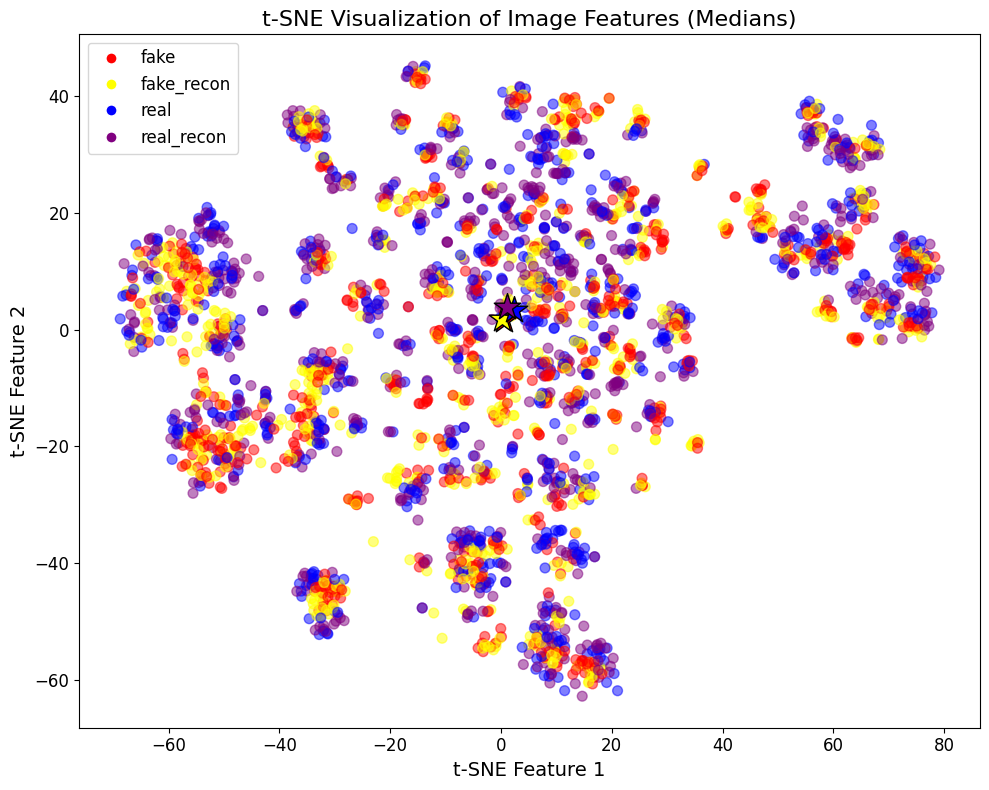

In [42]:

tsne = TSNE(n_components=2, learning_rate=1000, perplexity=50).fit_transform(features4)

tx = tsne[:, 0]
ty = tsne[:, 1]

# 색상 매핑 (기존 코드와 동일)
color_map = {
    'fake': 'red',
    'fake_recon': 'yellow',
    'real': 'blue',
    'real_recon': 'purple'
}

colors = [color_map[label] for label in labels4]

# 중앙값 계산 (기존 코드와 동일)
cluster_medians = {}
for label in color_map:
    indices = [i for i, l in enumerate(labels4) if l == label]
    if indices:
        cluster_tx = np.median(tx[indices])
        cluster_ty = np.median(ty[indices])
        cluster_medians[label] = (cluster_tx, cluster_ty)

# 시각화 (개선된 부분)
plt.figure(figsize=(10, 8))  # Figure 크기 확대
plt.scatter(tx, ty, c=colors, label='Images', alpha=0.5, s=50)  # 점 크기 확대

# 중앙값 강조 표시
for label, (center_tx, center_ty) in cluster_medians.items():
    plt.scatter(center_tx, center_ty, marker='*', s=400,  # 마커 크기 확대
                color=color_map[label], label=f'{label} Median',  # 레이블에 Median 명시
                edgecolors='black', linewidths=1)  # 마커 테두리 추가

# 범례 (개선된 부분)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=8) for label, color in color_map.items()]  # 범례 마커 크기 확대
# handles.extend([plt.Line2D([0], [0], marker='*', markersize=15,  # 범례 중앙값 마커 크기 확대
#                             color=color_map[label], label=f'{label} Median',
#                             markeredgecolor='black') for label in color_map])  # 범례 마커 테두리 추가
plt.legend(handles=handles, fontsize=12)  # 범례 글자 크기 확대

plt.title("t-SNE Visualization of Image Features (Medians)", fontsize=16)  # 제목 글자 크기 확대
plt.xlabel("t-SNE Feature 1", fontsize=14)  # 축 레이블 글자 크기 확대
plt.ylabel("t-SNE Feature 2", fontsize=14)
plt.xticks(fontsize=12)  # 축 눈금 글자 크기 확대
plt.yticks(fontsize=12)

plt.tight_layout()  # 여백 조정
plt.show()